Epoch [1/5], Loss: 0.1948
Epoch [2/5], Loss: 0.5290
Epoch [3/5], Loss: 0.1332
Epoch [4/5], Loss: 0.3023
Epoch [5/5], Loss: 0.2655
Accuracy of the model on the 10000 test images: 92.45 %


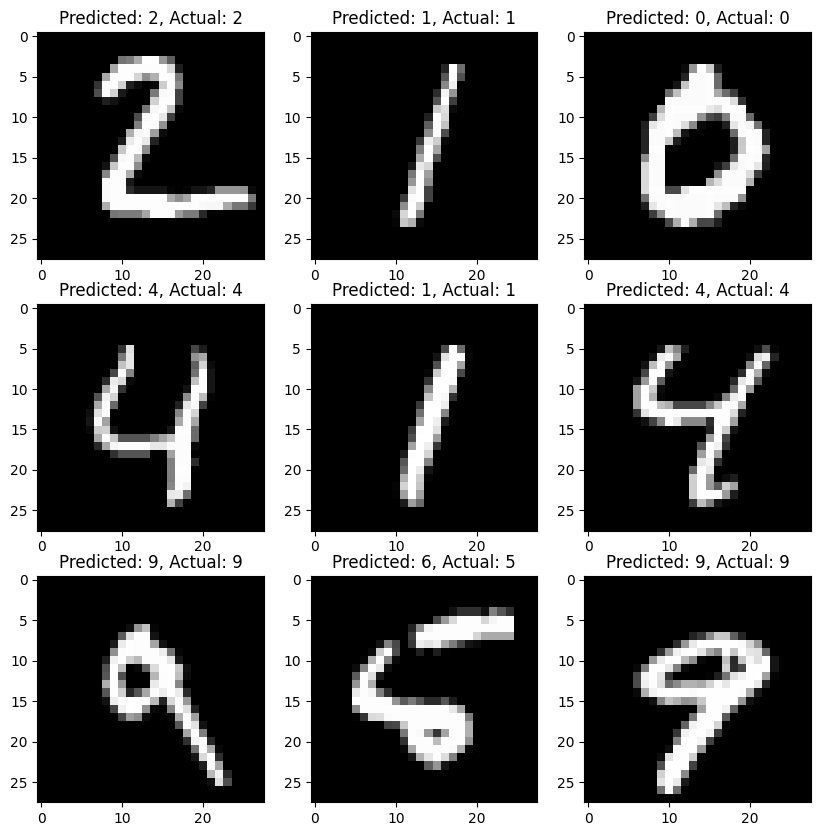

In [64]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 检查CUDA可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 定义Transformer模型框架
class SimpleTransformer(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(SimpleTransformer, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        output = self.linear(x)
        return output

# 2. 准备数据集
def get_data_loaders(batch_size=64):
    train_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# 3. 训练模型
def train_model(model, data_loader, epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model.to(device)
    model.train()

    for epoch in range(epochs):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 4. 保存模型
def save_model(model, path="mnist_transformer.pth"):
    torch.save(model.state_dict(), path)

# 5. 加载模型
def load_model(path="mnist_transformer.pth"):
    model = SimpleTransformer()
    model.load_state_dict(torch.load(path, map_location=device))
    return model

# 6. 测试和可视化
def test_and_visualize(model, data_loader):
    model.eval()
    model.to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')

    # 可视化部分测试结果
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 10))
    for i in range(1, 10):
        img = images[i].cpu().squeeze()
        ax = fig.add_subplot(3, 3, i)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Predicted: {predicted[i]}, Actual: {labels[i]}")
    plt.show()

# 执行训练和测试
model = SimpleTransformer()
train_loader, test_loader = get_data_loaders()
train_model(model, train_loader)
save_model(model)
model = load_model()
test_and_visualize(model, test_loader)
